In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import re

In [3]:
import datetime

In [4]:
import os

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from plotting import *

In [7]:
import matplotlib.dates as mdt

In [8]:
from matplotlib.ticker import MaxNLocator


#### Example of parsing profile line

In [9]:
pline = 'I1220 00:17:46.184228 128107 solver.cpp:291] [1] PROFILING BEGIN[Forward] Iteration 1'

In [10]:
pd = parse_profile_log_line(pline)
pd

{'pid': 128107,
 'prof_event': 'BEGIN',
 'prof_name': 'Forward',
 'remainder': '[1] PROFILING BEGIN[Forward] Iteration 1',
 'source_line': 'solver.cpp:291',
 'time': datetime.datetime(2016, 12, 20, 0, 17, 46, 184228),
 'worker_id': 1}

## Processing a bunch of profile lines

In [89]:
def plot_profile_fb(log_file, line_limit=None):

    all_events = load_profiling_info(log_file, line_limit=line_limit)

    dt0 = all_events[0]['time']

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    for event in filter(lambda entry: entry['prof_event']=='BEGIN', all_events):
        # Find end event
        end_event = filter(lambda entry: (
                                entry['prof_event']=='END' and
                                entry['prof_name']==event['prof_name'] and
                                entry['worker_id']==event['worker_id'] 
                                and entry['time']>event['time']
                                #and entry['iteration']==event['iteration']
                    ), all_events)

        if len(end_event)>0:
            end_event = end_event[0]
        else:
            continue

        yvalue = event['worker_id']

        start_time = (event['time']-dt0).total_seconds()
        end_time = (end_event['time']-dt0).total_seconds()
        end_time = 1.0*(end_time-start_time) + start_time
        
        alpha=1.0

        if event['prof_name']=='Forward':
            yvalue-=0.1
            color = 'blue'
        elif event['prof_name']=='Backward':
            color = 'green'
        elif event['prof_name']=='WaitingToSync':
            yvalue+=0.1
            color = 'red'
            alpha=0.3
        else:
            color = 'green'
            yvalue+=0.1


        ax = plt.hlines(
            yvalue,
            start_time, end_time,
            color=color,
            linewidth=8,
            alpha=alpha
        )

    plt.grid()
    plt.ylabel('Worker ID')
    plt.xlabel('Time')
    plt.axis([None, 15, -0.5, None]);
    plt.title(log_file)
    print 'Blue==Forward'
    print 'Green==Backward OR PSUpdate'
    print 'Red==WaitingToSync'

#### vLab: 8 workers, 1 group

Blue==Forward
Green==Backward OR PSUpdate
Red==WaitingToSync


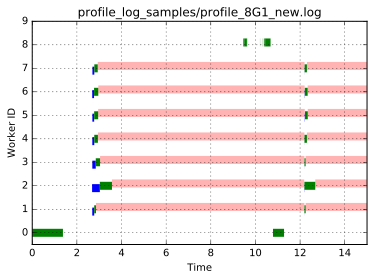

In [90]:
plot_profile_fb('profile_log_samples/profile_8G1_new.log')

Blue==Forward
Green==Backward OR PSUpdate
Red==WaitingToSync


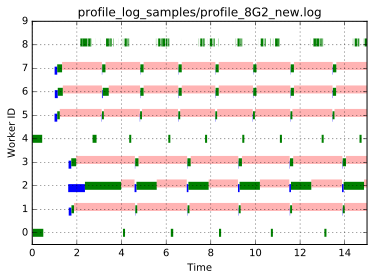

In [91]:
plot_profile_fb('profile_log_samples/profile_8G2_new.log', line_limit=1000)

Blue==Forward
Green==Backward OR PSUpdate
Red==WaitingToSync


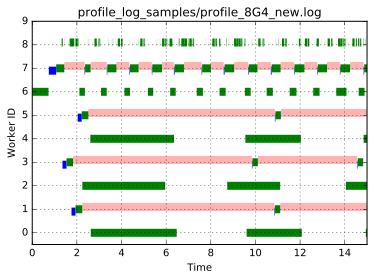

In [93]:
plot_profile_fb('profile_log_samples/profile_8G4_new.log', line_limit=1000)

#### vLab: 8 workers, 8 groups

Blue==Forward
Green==Backward OR PSUpdate
Red==WaitingToSync


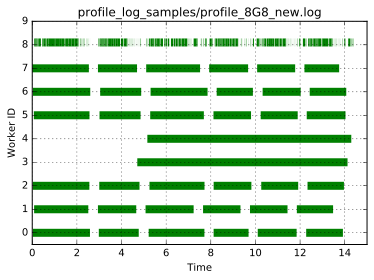

In [96]:
plot_profile_fb('profile_log_samples/profile_8G8_new.log', line_limit=1400)

## OLDER 

Blue==Forward
Green==Backward
Red==WaitingToSync


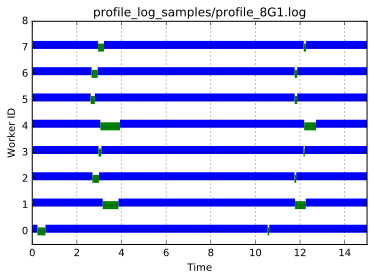

In [51]:
plot_profile_fb('profile_log_samples/profile_8G1.log')

Blue==Forward
Green==Backward
Red==WaitingToSync


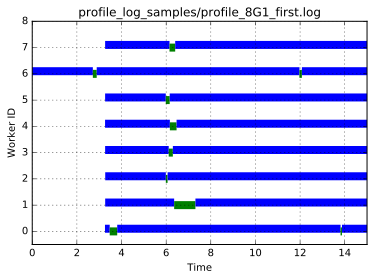

In [52]:
plot_profile_fb('profile_log_samples/profile_8G1_first.log')

#### vLab: 8 workers, 2 groups

Blue==Forward
Red==Backward


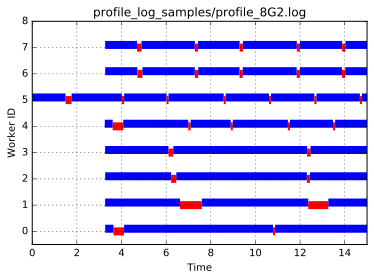

In [39]:
plot_profile_fb('profile_log_samples/profile_8G2.log')

Blue==Forward
Green==Backward
Red==WaitingToSync


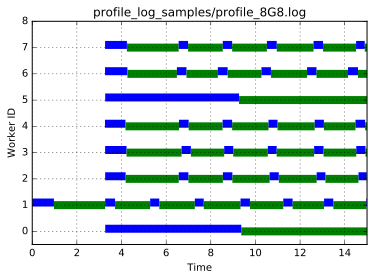

In [55]:
plot_profile_fb('profile_log_samples/profile_8G8.log')

## OTHER EXAMPLES. NOT IMPORTANT

#### Fake example

In [28]:
plines =[
    'I1220 00:17:46.184228 128107 solver.cpp:291] [1] PROFILING BEGIN[Forward] Iteration 1',
    'I1220 00:17:46.284228 128107 solver.cpp:291] [2] PROFILING BEGIN[Forward] Iteration 1',
    'I1220 00:17:47.084228 128107 solver.cpp:291] [2] PROFILING END[Forward] Iteration 1',
    'I1220 00:17:47.088228 128107 solver.cpp:291] [2] PROFILING BEGIN[Backward] Iteration 1',
    'I1220 00:17:47.184228 128107 solver.cpp:291] [1] PROFILING END[Forward] Iteration 1',
    'I1220 00:17:47.188228 128107 solver.cpp:291] [1] PROFILING BEGIN[Backward] Iteration 1',
    'I1220 00:17:48.088228 128107 solver.cpp:291] [2] PROFILING END[Backward] Iteration 1',
    'I1220 00:17:48.188228 128107 solver.cpp:291] [1] PROFILING END[Backward] Iteration 1',
    'I1220 00:17:48.284228 128107 solver.cpp:291] [1] PROFILING BEGIN[Forward] Iteration 2',
    'I1220 00:17:48.384228 128107 solver.cpp:291] [2] PROFILING BEGIN[Forward] Iteration 2',
    'I1220 00:17:49.184228 128107 solver.cpp:291] [2] PROFILING END[Forward] Iteration 2',
    'I1220 00:17:49.188228 128107 solver.cpp:291] [2] PROFILING BEGIN[Backward] Iteration 2',
    'I1220 00:17:49.284228 128107 solver.cpp:291] [1] PROFILING END[Forward] Iteration 2',
    'I1220 00:17:49.288228 128107 solver.cpp:291] [1] PROFILING BEGIN[Backward] Iteration 2',
    'I1220 00:17:50.188228 128107 solver.cpp:291] [2] PROFILING END[Backward] Iteration 2',
    'I1220 00:17:50.288228 128107 solver.cpp:291] [1] PROFILING END[Backward] Iteration 2'
]

In [30]:
all_events = []

for line in plines:
    parsed_dict = parse_profile_log_line(line)
    if parsed_dict:
        all_events.append(parsed_dict)

Blue==Forward
Red==Backward


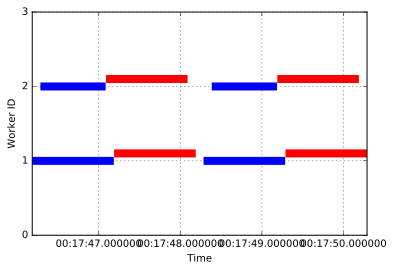

In [31]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.xaxis_date()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.hlines()
for event in filter(lambda entry: entry['prof_event']=='BEGIN', all_events):
    # Find end event
    end_event = filter(lambda entry: (
                            entry['prof_event']=='END' and
                            entry['prof_name']==event['prof_name'] and
                            entry['worker_id']==event['worker_id'] and
                            entry['iteration']==event['iteration']
                ), all_events)[0]
    
    yvalue = event['worker_id']
    if event['prof_name']=='Backward':
        yvalue+=0.1
        color = 'red'
    else:
        color = 'blue'
        
    ax = plt.hlines(
        yvalue,
        mdt.date2num(event['time']), mdt.date2num(end_event['time']),
        color=color,
        linewidth=8
    )
plt.grid()
plt.ylabel('Worker ID')
plt.xlabel('Time')
plt.axis([None, None, 0, None]);
print 'Blue==Forward'
print 'Red==Backward'

#### Real log from vLab

In [32]:
plines_txt = """I1226 02:38:59.856094 89917 solver.cpp:298] [0] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.857645 92857 solver.cpp:298] [2] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.862138 90596 solver.cpp:298] [3] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.860656 91729 solver.cpp:298] [5] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.867382 88227 solver.cpp:369] Learning Rate Policy: step
I1226 02:38:59.875888 88150 solver.cpp:369] Learning Rate Policy: step
I1226 02:38:59.848455 87957 solver.cpp:369] Learning Rate Policy: step
I1226 02:38:59.861383 92926 SynchronousNode.cpp:280] [2] Comm thread started 1 0
I1226 02:38:59.866111 90667 SynchronousNode.cpp:280] [3] Comm thread started 1 0
I1226 02:38:59.860991 87712 solver.cpp:298] [4] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.867642 88227 solver.cpp:298] [1] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.876171 88150 solver.cpp:298] [7] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.848711 87957 solver.cpp:298] [6] PROFILING BEGIN[Forward] Iteration 1
I1226 02:38:59.867719 84411 async_param_server.cpp:175] PS: Compute loop
I1226 02:38:59.862030 88028 SynchronousNode.cpp:280] [6] Comm thread started 1 0
I1226 02:38:59.881745 91801 SynchronousNode.cpp:280] [5] Comm thread started 0 0
I1226 02:38:59.884977 89988 SynchronousNode.cpp:280] [0] Comm thread started 0 1
I1226 02:38:59.890916 87785 SynchronousNode.cpp:280] [4] Comm thread started 0 1
I1226 02:38:59.911856 88220 SynchronousNode.cpp:280] [7] Comm thread started 1 0
I1226 02:38:59.897720 87785 SynchronousNode.cpp:466] [4] initialized root of cluster with nodes: 9 and the total iter size is: 4
I1226 02:38:59.905534 88298 SynchronousNode.cpp:280] [1] Comm thread started 0 0
I1226 02:38:59.916859 89988 SynchronousNode.cpp:466] [0] initialized root of cluster with nodes: 9 and the total iter size is: 4
I1226 02:39:00.672089 89917 solver.cpp:304] [0] Iteration 1, loss = 3.18796
I1226 02:39:00.672686 89917 solver.cpp:307] [0] PROFILING END[Forward] Iteration 1
I1226 02:39:00.673163 89917 solver.cpp:331]     Train net output #0: accuracy = 0.34375
I1226 02:39:00.673532 89917 solver.cpp:331]     Train net output #1: loss = 3.18796 (* 1 = 3.18796 loss)
I1226 02:39:00.674068 89917 solver.cpp:298] [0] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:00.730676 87712 solver.cpp:304] [4] Iteration 1, loss = 3.12073
I1226 02:39:00.730787 87712 solver.cpp:307] [4] PROFILING END[Forward] Iteration 1
I1226 02:39:00.730865 87712 solver.cpp:331]     Train net output #0: accuracy = 0.328125
I1226 02:39:00.730943 87712 solver.cpp:331]     Train net output #1: loss = 3.12073 (* 1 = 3.12073 loss)
I1226 02:39:00.731001 87712 solver.cpp:298] [4] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:02.177826 88227 solver.cpp:304] [1] Iteration 1, loss = 2.95831
I1226 02:39:02.177932 88227 solver.cpp:307] [1] PROFILING END[Forward] Iteration 1
I1226 02:39:02.177983 88227 solver.cpp:331]     Train net output #0: accuracy = 0.390625
I1226 02:39:02.178053 88227 solver.cpp:331]     Train net output #1: loss = 2.95831 (* 1 = 2.95831 loss)
I1226 02:39:02.178141 88227 solver.cpp:298] [1] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:03.140976 88150 solver.cpp:304] [7] Iteration 1, loss = 3.49365
I1226 02:39:03.141145 88150 solver.cpp:307] [7] PROFILING END[Forward] Iteration 1
I1226 02:39:03.141225 88150 solver.cpp:331]     Train net output #0: accuracy = 0.296875
I1226 02:39:03.141317 88150 solver.cpp:331]     Train net output #1: loss = 3.49365 (* 1 = 3.49365 loss)
I1226 02:39:03.141413 88150 solver.cpp:298] [7] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:03.115407 87957 solver.cpp:304] [6] Iteration 1, loss = 3.14037
I1226 02:39:03.115520 87957 solver.cpp:307] [6] PROFILING END[Forward] Iteration 1
I1226 02:39:03.115581 87957 solver.cpp:331]     Train net output #0: accuracy = 0.328125
I1226 02:39:03.115702 87957 solver.cpp:331]     Train net output #1: loss = 3.14037 (* 1 = 3.14037 loss)
I1226 02:39:03.115774 87957 solver.cpp:298] [6] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:03.714085 90596 solver.cpp:304] [3] Iteration 1, loss = 2.8636
I1226 02:39:03.714205 90596 solver.cpp:307] [3] PROFILING END[Forward] Iteration 1
I1226 02:39:03.714265 90596 solver.cpp:331]     Train net output #0: accuracy = 0.375
I1226 02:39:03.714388 90596 solver.cpp:331]     Train net output #1: loss = 2.8636 (* 1 = 2.8636 loss)
I1226 02:39:03.714637 90596 solver.cpp:298] [3] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:03.733232 92857 solver.cpp:304] [2] Iteration 1, loss = 3.30971
I1226 02:39:03.733355 92857 solver.cpp:307] [2] PROFILING END[Forward] Iteration 1
I1226 02:39:03.733413 92857 solver.cpp:331]     Train net output #0: accuracy = 0.265625
I1226 02:39:03.733497 92857 solver.cpp:331]     Train net output #1: loss = 3.30971 (* 1 = 3.30971 loss)
I1226 02:39:03.733572 92857 solver.cpp:298] [2] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:04.190564 91729 solver.cpp:304] [5] Iteration 1, loss = 3.319
I1226 02:39:04.190681 91729 solver.cpp:307] [5] PROFILING END[Forward] Iteration 1
I1226 02:39:04.190733 91729 solver.cpp:331]     Train net output #0: accuracy = 0.265625
I1226 02:39:04.190831 91729 solver.cpp:331]     Train net output #1: loss = 3.319 (* 1 = 3.319 loss)
I1226 02:39:04.190888 91729 solver.cpp:298] [5] PROFILING BEGIN[Forward] Iteration 2
I1226 02:39:04.408244 89917 solver.cpp:304] [0] Iteration 2, loss = 3.53788
I1226 02:39:04.408352 89917 solver.cpp:307] [0] PROFILING END[Forward] Iteration 2
I1226 02:39:04.408437 89917 solver.cpp:331]     Train net output #0: accuracy = 0.28125
I1226 02:39:04.408496 89917 solver.cpp:331]     Train net output #1: loss = 3.53788 (* 1 = 3.53788 loss)
I1226 02:39:04.408561 89917 solver.cpp:298] [0] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:05.445168 88227 solver.cpp:304] [1] Iteration 2, loss = 3.54725
I1226 02:39:05.445276 88227 solver.cpp:307] [1] PROFILING END[Forward] Iteration 2
I1226 02:39:05.445318 88227 solver.cpp:331]     Train net output #0: accuracy = 0.25
I1226 02:39:05.445385 88227 solver.cpp:331]     Train net output #1: loss = 3.54725 (* 1 = 3.54725 loss)
I1226 02:39:05.445541 88227 solver.cpp:298] [1] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:06.288316 92857 solver.cpp:304] [2] Iteration 2, loss = 3.65687
I1226 02:39:06.288524 92857 solver.cpp:307] [2] PROFILING END[Forward] Iteration 2
I1226 02:39:06.288573 92857 solver.cpp:331]     Train net output #0: accuracy = 0.296875
I1226 02:39:06.288650 92857 solver.cpp:331]     Train net output #1: loss = 3.65687 (* 1 = 3.65687 loss)
I1226 02:39:06.288718 92857 solver.cpp:298] [2] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:06.294004 90596 solver.cpp:304] [3] Iteration 2, loss = 2.73976
I1226 02:39:06.294298 90596 solver.cpp:307] [3] PROFILING END[Forward] Iteration 2
I1226 02:39:06.294355 90596 solver.cpp:331]     Train net output #0: accuracy = 0.421875
I1226 02:39:06.294443 90596 solver.cpp:331]     Train net output #1: loss = 2.73976 (* 1 = 2.73976 loss)
I1226 02:39:06.294520 90596 solver.cpp:298] [3] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:06.899080 89917 solver.cpp:304] [0] Iteration 3, loss = 3.3487
I1226 02:39:06.899190 89917 solver.cpp:307] [0] PROFILING END[Forward] Iteration 3
I1226 02:39:06.899230 89917 solver.cpp:331]     Train net output #0: accuracy = 0.34375
I1226 02:39:06.899294 89917 solver.cpp:331]     Train net output #1: loss = 3.3487 (* 1 = 3.3487 loss)
I1226 02:39:06.899432 89917 solver.cpp:298] [0] PROFILING BEGIN[Forward] Iteration 4
I1226 02:39:07.150418 87712 solver.cpp:304] [4] Iteration 2, loss = 3.649
I1226 02:39:07.150522 87712 solver.cpp:307] [4] PROFILING END[Forward] Iteration 2
I1226 02:39:07.150563 87712 solver.cpp:331]     Train net output #0: accuracy = 0.25
I1226 02:39:07.150666 87712 solver.cpp:331]     Train net output #1: loss = 3.649 (* 1 = 3.649 loss)
I1226 02:39:07.150913 87712 solver.cpp:298] [4] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:07.858314 88227 solver.cpp:304] [1] Iteration 3, loss = 4.02702
I1226 02:39:07.858420 88227 solver.cpp:307] [1] PROFILING END[Forward] Iteration 3
I1226 02:39:07.858489 88227 solver.cpp:331]     Train net output #0: accuracy = 0.171875
I1226 02:39:07.858553 88227 solver.cpp:331]     Train net output #1: loss = 4.02702 (* 1 = 4.02702 loss)
I1226 02:39:07.858621 88227 solver.cpp:298] [1] PROFILING BEGIN[Forward] Iteration 4
I1226 02:39:08.724525 92857 solver.cpp:304] [2] Iteration 3, loss = 3.1233
I1226 02:39:08.724637 92857 solver.cpp:307] [2] PROFILING END[Forward] Iteration 3
I1226 02:39:08.724683 92857 solver.cpp:331]     Train net output #0: accuracy = 0.328125
I1226 02:39:08.724788 92857 solver.cpp:331]     Train net output #1: loss = 3.1233 (* 1 = 3.1233 loss)
I1226 02:39:08.724915 92857 solver.cpp:298] [2] PROFILING BEGIN[Forward] Iteration 4
I1226 02:39:08.958809 87957 solver.cpp:304] [6] Iteration 2, loss = 2.99145
I1226 02:39:08.958920 87957 solver.cpp:307] [6] PROFILING END[Forward] Iteration 2
I1226 02:39:08.958979 87957 solver.cpp:331]     Train net output #0: accuracy = 0.328125
I1226 02:39:08.959058 87957 solver.cpp:331]     Train net output #1: loss = 2.99145 (* 1 = 2.99145 loss)
I1226 02:39:08.959136 87957 solver.cpp:298] [6] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:09.011323 88150 solver.cpp:304] [7] Iteration 2, loss = 3.42928
I1226 02:39:09.011446 88150 solver.cpp:307] [7] PROFILING END[Forward] Iteration 2
I1226 02:39:09.011509 88150 solver.cpp:331]     Train net output #0: accuracy = 0.265625
I1226 02:39:09.011600 88150 solver.cpp:331]     Train net output #1: loss = 3.42928 (* 1 = 3.42928 loss)
I1226 02:39:09.011706 88150 solver.cpp:298] [7] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:09.239250 90596 solver.cpp:304] [3] Iteration 3, loss = 2.71781
I1226 02:39:09.240643 90596 solver.cpp:307] [3] PROFILING END[Forward] Iteration 3
I1226 02:39:09.240711 90596 solver.cpp:331]     Train net output #0: accuracy = 0.453125
I1226 02:39:09.240815 90596 solver.cpp:331]     Train net output #1: loss = 2.71781 (* 1 = 2.71781 loss)
I1226 02:39:09.240905 90596 solver.cpp:298] [3] PROFILING BEGIN[Forward] Iteration 4
I1226 02:39:09.483942 89917 solver.cpp:304] [0] Iteration 4, loss = 3.52184
I1226 02:39:09.484042 89917 solver.cpp:307] [0] PROFILING END[Forward] Iteration 4
I1226 02:39:09.484079 89917 solver.cpp:331]     Train net output #0: accuracy = 0.25
I1226 02:39:09.484146 89917 solver.cpp:331]     Train net output #1: loss = 3.52184 (* 1 = 3.52184 loss)
I1226 02:39:09.484217 89917 solver.cpp:298] [0] PROFILING BEGIN[Forward] Iteration 5
I1226 02:39:09.792008 91729 solver.cpp:304] [5] Iteration 2, loss = 3.59114
I1226 02:39:09.793222 91729 solver.cpp:307] [5] PROFILING END[Forward] Iteration 2
I1226 02:39:09.793282 91729 solver.cpp:331]     Train net output #0: accuracy = 0.234375
I1226 02:39:09.793372 91729 solver.cpp:331]     Train net output #1: loss = 3.59114 (* 1 = 3.59114 loss)
I1226 02:39:09.793444 91729 solver.cpp:298] [5] PROFILING BEGIN[Forward] Iteration 3
I1226 02:39:10.527353 88227 solver.cpp:304] [1] Iteration 4, loss = 3.46452
I1226 02:39:10.527487 88227 solver.cpp:307] [1] PROFILING END[Forward] Iteration 4
I1226 02:39:10.527529 88227 solver.cpp:331]     Train net output #0: accuracy = 0.375
I1226 02:39:10.527595 88227 solver.cpp:331]     Train net output #1: loss = 3.46452 (* 1 = 3.46452 loss)
I1226 02:39:10.527655 88227 solver.cpp:298] [1] PROFILING BEGIN[Forward] Iteration 5
I1226 02:39:11.395197 92857 solver.cpp:304] [2] Iteration 4, loss = 3.56204
I1226 02:39:11.396677 92857 solver.cpp:307] [2] PROFILING END[Forward] Iteration 4
I1226 02:39:11.396981 92857 solver.cpp:331]     Train net output #0: accuracy = 0.265625
I1226 02:39:11.397076 92857 solver.cpp:331]     Train net output #1: loss = 3.56204 (* 1 = 3.56204 loss)
I1226 02:39:11.397213 92857 solver.cpp:298] [2] PROFILING BEGIN[Forward] Iteration 5
I1226 02:39:11.405916 90596 solver.cpp:304] [3] Iteration 4, loss = 3.66669
I1226 02:39:11.406049 90596 solver.cpp:307] [3] PROFILING END[Forward] Iteration 4
I1226 02:39:11.406096 90596 solver.cpp:331]     Train net output #0: accuracy = 0.265625
I1226 02:39:11.406177 90596 solver.cpp:331]     Train net output #1: loss = 3.66669 (* 1 = 3.66669 loss)
I1226 02:39:11.406296 90596 solver.cpp:298] [3] PROFILING BEGIN[Forward] Iteration 5
I1226 02:39:11.909828 89917 solver.cpp:304] [0] Iteration 5, loss = 3.36482
I1226 02:39:11.909931 89917 solver.cpp:307] [0] PROFILING END[Forward] Iteration 5
I1226 02:39:11.909968 89917 solver.cpp:331]     Train net output #0: accuracy = 0.265625
I1226 02:39:11.910038 89917 solver.cpp:331]     Train net output #1: loss = 3.36482 (* 1 = 3.36482 loss)
I1226 02:39:11.910114 89917 solver.cpp:298] [0] PROFILING BEGIN[Forward] Iteration 6
I1226 02:39:12.839761 88227 solver.cpp:304] [1] Iteration 5, loss = 3.3068
I1226 02:39:12.839864 88227 solver.cpp:307] [1] PROFILING END[Forward] Iteration 5
"""

In [33]:
plines = plines_txt.split('\n')

In [34]:
all_events = []

for line in plines:
    parsed_dict = parse_profile_log_line(line)
    if parsed_dict:
        all_events.append(parsed_dict)

Blue==Forward
Red==Backward


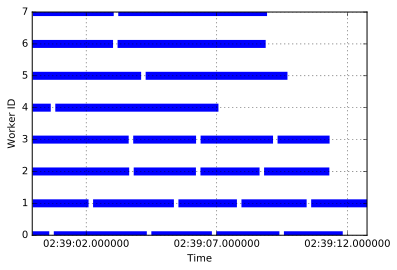

In [43]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.xaxis_date()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.hlines()
for event in filter(lambda entry: entry['prof_event']=='BEGIN', all_events):
    # Find end event
    end_event = filter(lambda entry: (
                            entry['prof_event']=='END' and
                            entry['prof_name']==event['prof_name'] and
                            entry['worker_id']==event['worker_id'] and
                            entry['iteration']==event['iteration']
                ), all_events)
    
    if len(end_event)>1:
        print('Found two END events for the same BEGIN event')
        break
    elif len(end_event)==0:
        continue
    else:
        end_event=end_event[0]
    
    yvalue = event['worker_id']
    if event['prof_name']=='Backward':
        yvalue+=0.1
        color = 'red'
    else:
        color = 'blue'
        
    ax = plt.hlines(
        yvalue,
        mdt.date2num(event['time'])+0.000001, mdt.date2num(end_event['time'])-0.000001,
        color=color,
        linewidth=8
    )
plt.grid()
plt.ylabel('Worker ID')
plt.xlabel('Time')
#plt.axis([None, None, 0, None]);
print 'Blue==Forward'
print 'Red==Backward'

Blue==Forward
Red==Backward


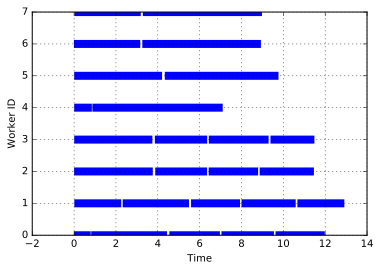

In [49]:
dt0 = all_events[0]['time']
#all_seconds = [(line[0]-dt0).total_seconds() % 86400 for line in all_lines]


fig=plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.hlines()
for event in filter(lambda entry: entry['prof_event']=='BEGIN', all_events):
    # Find end event
    end_event = filter(lambda entry: (
                            entry['prof_event']=='END' and
                            entry['prof_name']==event['prof_name'] and
                            entry['worker_id']==event['worker_id'] and
                            entry['iteration']==event['iteration']
                ), all_events)
    
    if len(end_event)>1:
        print('Found two END events for the same BEGIN event')
        break
    elif len(end_event)==0:
        continue
    else:
        end_event=end_event[0]
    
    yvalue = event['worker_id']
    if event['prof_name']=='Backward':
        yvalue+=0.1
        color = 'red'
    else:
        color = 'blue'
        
    start_time = (event['time']-dt0).total_seconds()
    end_time = (end_event['time']-dt0).total_seconds()
    
    end_time = 0.97*(end_time-start_time) + start_time
        
    ax = plt.hlines(
        yvalue,
        start_time, end_time,
        color=color,
        linewidth=8
    )
plt.grid()
plt.ylabel('Worker ID')
plt.xlabel('Time')
#plt.axis([None, None, 0, None]);
print 'Blue==Forward'
print 'Red==Backward'

## APPENDIX: New-style loss loading (not used yet) 

#### Example of parsing loss line

In [9]:
line = 'I1220 00:17:46.184228 128107 solver.cpp:291] [36] Iteration 1, loss = 0'
line = 'I1220 00:17:47.069375 128184 solver.cpp:291] [46] Iteration 3, loss = -3.74019e-06'

In [10]:
pd = parse_loss_log_line(line)
pd

{'iteration': 3,
 'loss': -3.74019e-06,
 'pid': 128184,
 'remainder': '[46] Iteration 3, loss = -3.74019e-06',
 'source_line': 'solver.cpp:291',
 'time': datetime.datetime(2016, 12, 20, 0, 17, 47, 69375),
 'worker_id': 46}

#### Example of loading losses for file with new code

In [11]:
all_losses = load_loss_info(logfile)

filtdict = filter(lambda entry: entry['worker_id']==46,all_losses)

filtdict[:3]

NameError: name 'logfile' is not defined